#### What is Augmentation?
- 기존의 데이터의 정보량을 보존한 상태로 노이즈를 주는 방식
- 역할: 학습될 수 있는 특징 공간을 조금이나마 더 넓혀 줄 수 있다는 점에 있다. 
- Random/Flip/Rotation/Scaling: 원본이미지를 자르거나, 회전하거나, 상하좌우 반전하거나, 크기를 확대하거나
- Cutout: 이미지의 일부를 검정색으로 칠해서(0으로 채워서) 불필요한 영역을 사용하지 않게함(input에 dropout한거와 같음)
- Cutmix: 두개의 이미지를 합쳐놓고 이미지의 Label을 학습시킬때 각각의 이미지가 차지하는 비율만큼 학습시키는 방법
#### Image Augmentation
- 원본 이미지에 인위적인 변화를 주는 것
- 인위적인 변화를 준 이미지는 충분히 학습에 활용될 수 있는 데이터가 된다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')
print('Using PyTorch version:',torch.__version__,'Device:',DEVICE)

Using PyTorch version: 1.8.1+cu101 Device: cpu


In [3]:
BATCH_SIZE=32
EPOCHS=10

In [6]:
# Augmentation 사용
train_dataset=datasets.CIFAR10(root='../data/CIFAR_10',
                               train=True,
                               download=True,
                               # 이미지 변형하기(data Argument)
                               #transform: 이미지 변형
                               transform=transforms.Compose([
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # 이미지를 랜덤으로 수평으로 뒤집는다.
                               ]))
test_dataset=datasets.CIFAR10(root='../data/CIFAR_10',
                              train=False,
                              transform=transforms.Compose([
                                                            transforms.RandomHorizontalFlip(),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                              ]))

# 다운받은 데이터셋 불러오기
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)

#파라미터
'''batch_size:모델을 한 번 학습시킬 때 몇 개의 데이터를 넣을지 정한다. 
              1배치가 끝날때마다 파라미터를 조정한다.
shuffle: 데이터를 섞을지 정한다.'''

Files already downloaded and verified


In [7]:
for (X_train,y_train) in train_loader:
    print('X_train:',X_train.size(),'type:',X_train.type())
    print('y_train:',y_train.size(),'type:',y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

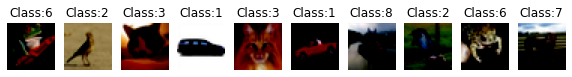

In [9]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))

for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class:'+str(y_train[i].item()))

In [10]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=8,kernel_size=3,padding=1)
    self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,padding=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
    self.fc1=nn.Linear(8*8*16,64)
    self.fc2=nn.Linear(64,32)
    self.fc3=nn.Linear(32,10)

  def forward(self,x):
    x=self.conv1(x)
    x=F.relu(x)
    x=self.pool(x)
    x=self.conv2(x)
    x=F.relu(x)
    x=self.pool(x)

    x=x.view(-1,8*8*16)
    x=self.fc1(x)
    x=F.relu(x)
    x=self.fc2(x)
    x=F.relu(x)
    x=self.fc3(x)
    x=F.log_softmax(x)
    return x
  

In [12]:
model=CNN().to(DEVICE)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
criterion=nn.CrossEntropyLoss()

print(model)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [22]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [23]:
def evaluate(model,test_loader):
  model.eval()
  test_loss=0
  correct=0

  with torch.no_grad():
    for image,label in test_loader:
      image=image.to(DEVICE)
      label=label.to(DEVICE)
      output=model(image)
      test_loss+=criterion(output,label).item()
      prediction=output.max(1,keepdim=True)[1]
      correct+=prediction.eq(label.view_as(prediction)).sum().item()

  test_loss/=(len(test_loader.dataset)/BATCH_SIZE)
  test_accuracy=100.*correct/len(test_loader.dataset)
  return test_loss,test_accuracy



In [24]:
for epoch in range(1,EPOCHS+1):
  train(model,train_loader,optimizer,log_interval=200)
  test_loss,test_accuracy=evaluate(model,test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.343617
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.767913
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.584246
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.494058
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.521955
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.429398
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.717493
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.301236

[EPOCH: 1], 	Test Loss: 1.3498, 	Test Accuracy: 51.59 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 1.506418
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.285570
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 1.248885
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.552939
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.065104
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 1.589571
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 1.118204
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 1.041827

[EPOCH: 2], 	Test Loss: 1.2236, 	Test Accuracy: 55.48 % 